# ADMM applied in Neural Networks with Mnist dataset


In [1]:
# Preparation with environment for notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from NeuralNetwork.data_utils import *

# Allow inline matplotlib figures appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Preprocessing and Loading of dataset

In [3]:
# Load Mnist Data
mnistDir = "NeuralNetwork/MnistData"
X_train,Y_train,X_test,Y_test = getMnistData(mnistDir)

# Check the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', Y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


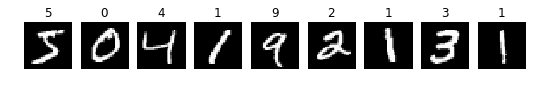

In [4]:
# Display part of the Mnist data
for xi in range(0,9):
    plt.subplot(1,10,xi+1)
    plt.imshow(X_train[xi])
    plt.axis('off')
    plt.title(Y_train[xi])

## Training the neural network

In [5]:
from NeuralNetwork.admm import *
import time
def getStatistics(Xtr, Ytr, Xte, Yte, weightConsWeight, activConsWeight, iterNum, epsilon):
    # Initialize a 3-layer neural network with specified neuron dimension, 
    # the first dim is determined by the size of input dataset
    neuronDim = [0, 150, 150]
    network = NeuralNetwork(3, neuronDim)
    classNum = 10
    
    # Initialize weight matrix W of first layer 
    W = np.random.randn(Xtr.shape[1], classNum) * epsilon

    # Train
    tic = time.time()
    weight = network.train(W, Xtr, Ytr, weightConsWeight, activConsWeight, iterNum, epsilon)
    toc = time.time()
    print 'Total training time: %fs' % (toc - tic)
    
    # Predict with the trained feature weight
    Ypred = network.predict(weight, Xte)
    print 'Prediction accuracy: %f' %np.mean(Ypred == Yte)

## Test the neural network

In [6]:
def miniPatchTest(trNum, teNum):
    # Subsample the data for more efficient code execution 
    trainNum = trNum
    mask = range(trainNum)
    Xtr = X_train[mask]
    Ytr = Y_train[mask]

    testNum = teNum
    mask = range(testNum)
    Xte = X_test[mask]
    Yte = Y_test[mask]
    
    # Reshape the image data into rows
    Xtr = np.reshape(Xtr, (Xtr.shape[0], -1))
    Xte = np.reshape(Xte, (Xte.shape[0], -1))
#     print Xtr.shape, Xte.shape

    # Specify weight coefficients of two regularization term, iteration of ADMM updates
    weightConsWeight = 1
    activConsWeight = 10
    iterNum = 10
    epsilon = 0.01
    getStatistics(Xtr, Ytr, Xte, Yte, weightConsWeight, activConsWeight, iterNum, epsilon)
    

train = np.array([1000])
for i in train:
    miniPatchTest(i,100)
# print "=================="
# for i in train:
#     miniPatchTest(i,5000)



Initializing a neural network:  3  layers; Neuron Dimension: [0, 1024, 1024]
Total training time: 27.253368s
Prediction accuracy: 0.160000


## For Testing 

In [196]:
# Testing Module
C = W.shape[1]
N = Xtr.shape[0]
L = 3
Dim = neuronDim
Dim[0] = Xtr.shape[1]
epsilon = 0.0001


print "C:%d N:%d L:%d epsilon:%f " %(C,N,L,epsilon), " ", Dim,

 C:10 N:200 L:3 epsilon:0.000100    [784, 100, 150]


In [197]:
# Main
def neuronReLU(x):
        """ Evaluate Rectified Linear Unit """
        # element wise
        xn = np.copy(x)
        xn[xn < 0] = 0
        return xn
    
def toHotOne(Y, C):
        """ Construct Hot-one representation of Y """
        y = np.zeros((Y.shape[0],C))
        for i in range(0,Y.shape[0]):
            y[i, Y[i]] = 1
        return y

def outputElementWiseCost(beta, aw, z, y, isOne):
        return hingeLossElementWiseCost(z,y, isOne) + beta * (z - aw) ** 2 

def regularElementWiseCost(beta, gamma, a, aw, z):
        """ Calculate elementwise cost """
        return  gamma * (a - neuronReLU(z)) ** 2 + beta * (z - wa) ** 2 
    
def hingeLossElementWiseCost(z, y, isOne):
        """ Evaluate Hinge Loss """
        zn = np.copy(z)
        x = np.zeros(z.shape)
        if not isOne:
            zn[y == 0] = np.maximum(zn,x)[y == 0]
        else:
            zn[y == 1] = np.maximum(1-zn,x)[y == 1]
        return zn

def regularElementWiseCost(beta, gamma, a, aw, z):
        """ Calculate elementwise cost """
        return  gamma * (a - neuronReLU(z)) ** 2 + beta * (z - aw) ** 2 
    

In [201]:
# Initialization 
# - a[]: activation list for each layer [a0, a1, a2]: a0(N,Dim[0]), a1(N,Dim[1]),a2(N,Dim[2])
# - z[]: z list for each layer [0, z1, z2, z3]: z1(N,Dim[1]),z2(N,Dim[2]), z3(N,C)
# - w[]: weight list for each layer  [0, w1, w2, w3]: w1(Dim[0],Dim[1]), w2(Dim[1],Dim[2]), w3(Dim[2],C)

a = [Xtr, epsilon*np.random.randn(N, Dim[1]), epsilon*np.random.randn(N, Dim[2])] # whether to vectorize
z = [np.zeros((0)), epsilon*np.random.randn(N, Dim[1]), epsilon*np.random.randn(N, Dim[2]), epsilon*np.random.randn(N, C)]
w = [np.zeros((0)), epsilon*np.random.randn(Dim[0], Dim[1]), epsilon*np.random.randn(Dim[1], Dim[2]), epsilon*np.random.randn(Dim[2], C)]

# - beta,gama: penalty coefficiencies
# - K: it  erations of ADMM
beta = 1.0 * weightConsWeight # 1
gamma = 1.0 * activConsWeight
K = iterNum

print "\n a: ",
for ai in a:
    print ai.shape,

print "\n z: ",
for ai in z:
    print ai.shape,

print "\n w: ",
for ai in w:
    print ai.shape,

print 

# Main part of ADMM updates
for k in range(K):
    # Walk through L-layer network
    for l in range(1, L):
        w[l] = np.linalg.pinv(a[l-1]).dot(z[l])
        wNtr = w[l+1].T
#         print  z[l+1].shape,wNtr.shape,w[l+1].shape
        x = beta * w[l+1].dot(wNtr) + gamma * np.identity(wNtr.shape[1])
#         print "",x[:5,:4], np.linalg.det(x),
        
        #a[l] = np.linalg.inv(beta * (w[l+1].dot(wNtr) + gamma)) * (beta * z[l+1].dot(wNtr)) + gamma * neuronReLU(z[l])
        a[l] = (beta * z[l+1].dot(wNtr) + gamma * neuronReLU(z[l])).dot(np.linalg.inv(beta * w[l+1].dot(wNtr) + gamma * np.identity(wNtr.shape[1])))

        
        
        # z update
        aw = a[l-1].dot(w[l])
        
        # z_i < 0
        z_s = np.copy(aw)
        z_s[z_s > 0] = 0
        l_s = regularElementWiseCost(beta, gamma, a[l], aw, z_s)

        # z_i > 0
        z_b = (gamma * a[l] + beta * z_s) / (beta + gamma)
        z_b[z_b < 0] = 0
        l_b = regularElementWiseCost(beta, gamma, a[l], aw, z_b)
        
        z_s[l_s > l_b] = z_b[l_s > l_b]
        z[l] = np.copy(z_s)
      
      
    # L-layer
    w[L] = np.linalg.pinv(a[L-1]).dot(z[L])
    

    # Transform y to hotone representation
    y = toHotOne(Ytr, C)

    # Hinge Loss
    awL = a[L-1].dot(w[L])
    zL = np.zeros(awL.shape)

    # y_i = 1
    # zi > 1
    zL_b = np.copy(awL)
    zL_b[zL_b < 1] = 1
    lL_b = outputElementWiseCost(beta, awL, zL_b, y, 1)
    
    # zi < 1
    zL_s = np.copy(awL + 1 / (2 * beta))
    zL_s[zL_s > 1] = 1
    lL_s = outputElementWiseCost(beta, awL, zL_s, y, 1)
    
    zL_s[lL_s > lL_b] = zL_b[lL_s > lL_b]
    zL[y == 1] = zL_s[y == 1]

    # y_i = 0
    # zi < 0
    zL_s = np.copy(awL)
    zL_s[zL_s > 0] = 0
    lL_s = outputElementWiseCost(beta, awL, zL_s, y, 0)

    # zi > 0
    zL_b = np.copy(awL - 1 / (2 * beta))
    zL_b[zL_b < 0] = 0
    lL_b = outputElementWiseCost(beta, awL, zL_b, y, 0)
        
    zL_s[lL_s > lL_b] = zL_b[lL_s > lL_b]
    zL[y == 0] = zL_s[y == 0]
    
    # Update zL
    z[L] = zL
    
    # Update beta, gamma
    beta *= 1.05
    gamma *= 1.05
    
    # Calculate loss
    #loss = calcuLoss(w, a, z, Ytr, gamma, beta)
    #print "Loss of iter ",k,":", loss

for i in range(1,L+1):
    print "w",i,": ", w[i][:5,:4]



 a:  (200, 784) (200, 100) (200, 150) 
 z:  (0,) (200, 100) (200, 150) (200, 10) 
 w:  (0,) (784, 100) (100, 150) (150, 10)
w 1 :  [[  6.73174109e-21  -3.55177491e-22  -3.00971339e-21  -6.47328761e-22]
 [ -6.69472848e-21  -9.62135974e-22  -2.23472719e-21  -5.81547743e-22]
 [ -6.93336007e-21   1.60449773e-22   1.23836964e-22   7.52271444e-23]
 [  1.40218760e-21  -1.00658415e-21   1.97234936e-21  -2.11409582e-21]
 [  1.37897920e-20   1.08097370e-21   2.93737749e-21  -2.12517557e-22]]
w 2 :  [[-0.05120213 -0.10317951 -0.01531815  0.12185371]
 [ 0.17040168 -0.05947507  0.46553075 -0.01965603]
 [ 0.28273424  0.32104814 -0.20826831 -0.45522063]
 [ 0.20066342 -0.10783917 -0.46707249 -0.27588645]
 [-0.15215018 -0.45553279 -0.28327806  0.40028184]]
w 3 :  [[-0.006073   -0.06824106  0.27906912  0.32243342]
 [-0.03666355  0.02531272  0.40318304  0.28581778]
 [ 0.12596102 -0.45680816  0.39253417 -0.36061932]
 [ 0.45670397  0.0740398  -0.31883678 -0.59107709]
 [-0.37295304  0.78690997  0.3894381  